# Predicting March Madness winners using automated feature engineering and head to head information

I hope this gives you the ability to see everything in one place. Let me know if you have any questions/issues.  
  
I only trained this model by predicting March Madness games to keep things simple for the Kaggle first pass but there is the capability to train it on a split of all games using the more advanced temporal feautures. 

In [1]:
#this is my standard way of handling path issues and shared libraries with Jupyter Notebooks
#Basically just set the path using the folder_name of the project and create any env variables
import sys,os
folder_name="march_madness"
BASE_DIR=os.path.abspath(".").split(folder_name)[0]+folder_name
DATA_ROOT=os.path.join(BASE_DIR,"data")
sys.path.insert(0, DATA_ROOT)

import utils
#use reload to easily reload changes
from importlib import reload
_=reload(utils)
import pandas as pd
np=pd.np
pd.options.display.max_rows=6#So we don't have to always write head
pd.options.display.max_columns=999
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import featuretools as ft
ft.__version__

'0.6.1'

# Load Data

Our matchup_es contains all regular season and NCAA tourney games

In [2]:
matchups_es=utils.load_matchups_entityset()
matchups_es

Entityset: None
  Entities:
    possible_matchups [Rows: 66795, Columns: 3]
    matchup_log [Rows: 83089, Columns: 41]
  Relationships:
    matchup_log.matchup_id -> possible_matchups.matchup_id

For all the statistics below see https://www.basketball-reference.com/about/glossary.html for an idea about names if you are unsure of the abbreviations

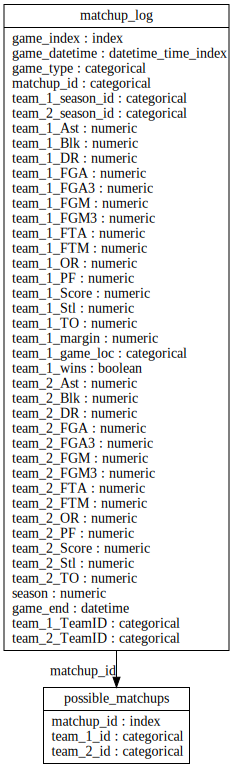

In [3]:
matchups_es.plot()

In [4]:
#I added a game_type column to allow using randomized time windows to train if we want to later
matchups_es["matchup_log"]["game_type"].interesting_values = ["regular_season", "march_madness"]
matchups_es["matchup_log"]["team_1_wins"].interesting_values = [False, True]

# Make Labels

We'll use tournament start dates to generate the predictions we need for Kaggle. The contest is to predict the outcome between any 2 possible March Madness matchups before the tourney. Only played games will be scored.  

In [5]:
matchup_logs=matchups_es['matchup_log'].df
tourney_starts=matchup_logs[matchup_logs['game_type']=='march_madness'].groupby("season").first()['game_datetime']
tourney_starts

season
2003   2003-03-18
2004   2004-03-16
2005   2005-03-15
          ...    
2016   2016-03-15
2017   2017-03-14
2018   2018-03-13
Name: game_datetime, Length: 16, dtype: datetime64[ns]

In [6]:
tourney_labels=utils.make_tourney_labels(matchups_es, tourney_starts)
tourney_labels

,game_index,time,team_1_wins
0,2003_145_1112_1242,2003-03-29,False
1,2004_136_1343_1400,2004-03-18,False
2,2004_139_1280_1462,2004-03-21,False
...,...,...,...
250,2018_146_1181_1242,2018-03-25,False
251,2018_152_1242_1437,2018-03-31,False
252,2018_154_1276_1437,2018-04-02,False


There are only 253 out of roughly 1040 games with matchup history available

Note: The labels use game_datetime. I ran into issues when I tried setting time to the actual tourney start date but this shouldn't matter for head to head matchup features because the tournament is single elimination. For team vs opponent stats this will need to be changed

In [7]:
labels=tourney_labels
#time window of march madness games in dataset is 16 years. 
#I left in instead of no training window to be explicit and because it's worth trying a few values to see if decaying trends exists
training_window=ft.Timedelta("16 years")
feature_matrix, features = ft.dfs(target_entity="matchup_log", 
                                  cutoff_time=labels,
                                  training_window=training_window,
                                  entityset=matchups_es,
                                  cutoff_time_in_index=True
                                 )
# encode categorical values
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)

print("Number of features %s" % len(features_encoded))
fm_encoded.head(10)

Number of features 387


,,game_type = march_madness,game_type is unknown,matchup_id = 1246_1452,matchup_id = 1242_1437,matchup_id = 1242_1314,matchup_id = 1181_1277,matchup_id = 1326_1397,matchup_id = 1277_1438,matchup_id = 1272_1417,matchup_id = 1266_1393,matchup_id = 1257_1287,matchup_id = 1246_1314,matchup_id is unknown,team_1_season_id = 2014_1163,team_1_season_id = 2014_1112,team_1_season_id = 2018_1181,team_1_season_id = 2017_1246,team_1_season_id = 2017_1211,team_1_season_id = 2016_1328,team_1_season_id = 2015_1181,team_1_season_id = 2012_1242,team_1_season_id = 2011_1112,team_1_season_id = 2006_1206,team_1_season_id is unknown,team_2_season_id = 2016_1437,team_2_season_id = 2015_1458,team_2_season_id = 2018_1437,team_2_season_id = 2017_1376,team_2_season_id = 2017_1332,team_2_season_id = 2017_1314,team_2_season_id = 2016_1438,team_2_season_id = 2013_1393,team_2_season_id = 2018_1452,team_2_season_id = 2018_1393,team_2_season_id is unknown,team_1_Ast,team_1_Blk,team_1_DR,team_1_FGA,team_1_FGA3,team_1_FGM,team_1_FGM3,team_1_FTA,team_1_FTM,team_1_OR,team_1_PF,team_1_Score,team_1_Stl,team_1_TO,team_1_margin,team_1_game_loc = N,team_1_game_loc is unknown,team_1_wins,team_2_Ast,team_2_Blk,team_2_DR,team_2_FGA,team_2_FGA3,team_2_FGM,team_2_FGM3,team_2_FTA,team_2_FTM,team_2_OR,team_2_PF,team_2_Score,team_2_Stl,team_2_TO,season,team_1_TeamID = 1242,team_1_TeamID = 1181,team_1_TeamID = 1246,team_1_TeamID = 1211,team_1_TeamID = 1112,team_1_TeamID = 1257,team_1_TeamID = 1277,team_1_TeamID = 1163,team_1_TeamID = 1139,team_1_TeamID = 1314,team_1_TeamID is unknown,team_2_TeamID = 1437,team_2_TeamID = 1314,team_2_TeamID = 1458,team_2_TeamID = 1277,team_2_TeamID = 1246,team_2_TeamID = 1452,team_2_TeamID = 1438,team_2_TeamID = 1417,team_2_TeamID = 1393,team_2_TeamID = 1462,team_2_TeamID is unknown,DAY(game_datetime) = 17,DAY(game_datetime) = 18,DAY(game_datetime) = 21,DAY(game_datetime) = 20,DAY(game_datetime) = 24,DAY(game_datetime) = 23,DAY(game_datetime) = 22,DAY(game_datetime) = 27,DAY(game_datetime) = 25,DAY(game_datetime) = 19,DAY(game_datetime) is unknown,DAY(game_end) is unknown,YEAR(game_datetime) = 2017,YEAR(game_datetime) = 2018,YEAR(game_datetime) = 2016,YEAR(game_datetime) = 2014,YEAR(game_datetime) = 2013,YEAR(game_datetime) = 2015,YEAR(game_datetime) = 2012,YEAR(game_datetime) = 2011,YEAR(game_datetime) = 2009,YEAR(game_datetime) = 2010,YEAR(game_datetime) is unknown,YEAR(game_end) is unknown,MONTH(game_datetime) = 3,MONTH(game_datetime) = 4,MONTH(game_datetime) is unknown,MONTH(game_end) is unknown,WEEKDAY(game_datetime) = 4,WEEKDAY(game_datetime) = 3,WEEKDAY(game_datetime) = 5,WEEKDAY(game_datetime) = 6,WEEKDAY(game_datetime) = 0,WEEKDAY(game_datetime) = 1,WEEKDAY(game_datetime) is unknown,WEEKDAY(game_end) is unknown,possible_matchups.team_1_id = 1242,possible_matchups.team_1_id = 1181,possible_matchups.team_1_id = 1246,possible_matchups.team_1_id = 1211,possible_matchups.team_1_id = 1112,possible_matchups.team_1_id = 1257,possible_matchups.team_1_id = 1277,possible_matchups.team_1_id = 1163,possible_matchups.team_1_id = 1139,possible_matchups.team_1_id = 1314,possible_matchups.team_1_id is unknown,possible_matchups.team_2_id = 1437,possible_matchups.team_2_id = 1314,possible_matchups.team_2_id = 1458,possible_matchups.team_2_id = 1277,possible_matchups.team_2_id = 1246,possible_matchups.team_2_id = 1452,possible_matchups.team_2_id = 1438,possible_matchups.team_2_id = 1417,possible_matchups.team_2_id = 1393,possible_matchups.team_2_id = 1462,possible_matchups.team_2_id is unknown,possible_matchups.SUM(matchup_log.team_1_Ast),possible_matchups.SUM(matchup_log.team_1_Blk),possible_matchups.SUM(matchup_log.team_1_DR),possible_matchups.SUM(matchup_log.team_1_FGA),possible_matchups.SUM(matchup_log.team_1_FGA3),possible_matchups.SUM(matchup_log.team_1_FGM),possible_matchups.SUM(matchup_log.team_1_FGM3),possible_matchups.SUM(matchup_log.team_1_FTA),possible_matchups.SUM(matchup_log.team_1_FTM),possible_matchups.SUM(matchup_log.team_1_OR),possible_ma

# Machine Learning

I found using fm_encoded and features_encoded with feature selection a little tricky compared to using the pandas columns so I didn't follow the example https://github.com/Featuretools/predict-next-purchase/blob/master/Tutorial.ipynb exactly

I used the fm_encoded matrix directly and used the raw pandas columns instead

In [8]:
X,y=utils.transform_to_Xy(fm_encoded, tourney_labels)
X

,game_type = march_madness,game_type is unknown,matchup_id = 1246_1452,matchup_id = 1242_1437,matchup_id = 1242_1314,matchup_id = 1181_1277,matchup_id = 1326_1397,matchup_id = 1277_1438,matchup_id = 1272_1417,matchup_id = 1266_1393,matchup_id = 1257_1287,matchup_id = 1246_1314,matchup_id is unknown,team_1_season_id = 2014_1163,team_1_season_id = 2014_1112,team_1_season_id = 2018_1181,team_1_season_id = 2017_1246,team_1_season_id = 2017_1211,team_1_season_id = 2016_1328,team_1_season_id = 2015_1181,team_1_season_id = 2012_1242,team_1_season_id = 2011_1112,team_1_season_id = 2006_1206,team_1_season_id is unknown,team_2_season_id = 2016_1437,team_2_season_id = 2015_1458,team_2_season_id = 2018_1437,team_2_season_id = 2017_1376,team_2_season_id = 2017_1332,team_2_season_id = 2017_1314,team_2_season_id = 2016_1438,team_2_season_id = 2013_1393,team_2_season_id = 2018_1452,team_2_season_id = 2018_1393,team_2_season_id is unknown,team_1_Ast,team_1_Blk,team_1_DR,team_1_FGA,team_1_FGA3,team_1_FGM,team_1_FGM3,team_1_FTA,team_1_FTM,team_1_OR,team_1_PF,team_1_Score,team_1_Stl,team_1_TO,team_1_margin,team_1_game_loc = N,team_1_game_loc is unknown,team_2_Ast,team_2_Blk,team_2_DR,team_2_FGA,team_2_FGA3,team_2_FGM,team_2_FGM3,team_2_FTA,team_2_FTM,team_2_OR,team_2_PF,team_2_Score,team_2_Stl,team_2_TO,season,team_1_TeamID = 1242,team_1_TeamID = 1181,team_1_TeamID = 1246,team_1_TeamID = 1211,team_1_TeamID = 1112,team_1_TeamID = 1257,team_1_TeamID = 1277,team_1_TeamID = 1163,team_1_TeamID = 1139,team_1_TeamID = 1314,team_1_TeamID is unknown,team_2_TeamID = 1437,team_2_TeamID = 1314,team_2_TeamID = 1458,team_2_TeamID = 1277,team_2_TeamID = 1246,team_2_TeamID = 1452,team_2_TeamID = 1438,team_2_TeamID = 1417,team_2_TeamID = 1393,team_2_TeamID = 1462,team_2_TeamID is unknown,DAY(game_datetime) = 17,DAY(game_datetime) = 18,DAY(game_datetime) = 21,DAY(game_datetime) = 20,DAY(game_datetime) = 24,DAY(game_datetime) = 23,DAY(game_datetime) = 22,DAY(game_datetime) = 27,DAY(game_datetime) = 25,DAY(game_datetime) = 19,DAY(game_datetime) is unknown,DAY(game_end) is unknown,YEAR(game_datetime) = 2017,YEAR(game_datetime) = 2018,YEAR(game_datetime) = 2016,YEAR(game_datetime) = 2014,YEAR(game_datetime) = 2013,YEAR(game_datetime) = 2015,YEAR(game_datetime) = 2012,YEAR(game_datetime) = 2011,YEAR(game_datetime) = 2009,YEAR(game_datetime) = 2010,YEAR(game_datetime) is unknown,YEAR(game_end) is unknown,MONTH(game_datetime) = 3,MONTH(game_datetime) = 4,MONTH(game_datetime) is unknown,MONTH(game_end) is unknown,WEEKDAY(game_datetime) = 4,WEEKDAY(game_datetime) = 3,WEEKDAY(game_datetime) = 5,WEEKDAY(game_datetime) = 6,WEEKDAY(game_datetime) = 0,WEEKDAY(game_datetime) = 1,WEEKDAY(game_datetime) is unknown,WEEKDAY(game_end) is unknown,possible_matchups.team_1_id = 1242,possible_matchups.team_1_id = 1181,possible_matchups.team_1_id = 1246,possible_matchups.team_1_id = 1211,possible_matchups.team_1_id = 1112,possible_matchups.team_1_id = 1257,possible_matchups.team_1_id = 1277,possible_matchups.team_1_id = 1163,possible_matchups.team_1_id = 1139,possible_matchups.team_1_id = 1314,possible_matchups.team_1_id is unknown,possible_matchups.team_2_id = 1437,possible_matchups.team_2_id = 1314,possible_matchups.team_2_id = 1458,possible_matchups.team_2_id = 1277,possible_matchups.team_2_id = 1246,possible_matchups.team_2_id = 1452,possible_matchups.team_2_id = 1438,possible_matchups.team_2_id = 1417,possible_matchups.team_2_id = 1393,possible_matchups.team_2_id = 1462,possible_matchups.team_2_id is unknown,possible_matchups.SUM(matchup_log.team_1_Ast),possible_matchups.SUM(matchup_log.team_1_Blk),possible_matchups.SUM(matchup_log.team_1_DR),possible_matchups.SUM(matchup_log.team_1_FGA),possible_matchups.SUM(matchup_log.team_1_FGA3),possible_matchups.SUM(matchup_log.team_1_FGM),possible_matchups.SUM(matchup_log.team_1_FGM3),possible_matchups.SUM(matchup_log.team_1_FTA),possible_matchups.SUM(matchup_log.team_1_FTM),possible_matchups.SUM(matchup_log.team_1_OR),possible_matchups.SUM(ma

In [9]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


'AUC 0.68 +/- 0.06'

High difference across folds. 

I think it's good to see how the model performs in training like scenarios beyond auc. For me, plausible accuracy numbers in NCAA basketball would be expected to cap around 80% or so in this head to head with historical data scenario. Any features found important that go beyond 80% start to make me more concerned that the model is overly biased.

From a few runs I think setting max_depth to 2 is a reasonable idea for feature selection:  
- The top-20 seem pretty similar with a trend towards more defensive and defensive penalty statistics as complexity of the random forest increases. 
  - Shooting fouls come more often from defensive penalties (play by play data could do a better job determining penalty source)
  - Defense wins championships
  - I think offensive features would be more prominent if we computed things like True Shooting Percentage or used FeatureTools to compute more complex features derived on feature groups. 
- Simpler forests gave more offensive statistics and had score derived stats like margin of victory in a higher spot.  

In [10]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=2)
TEST_SIZE=.5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=23
)

#
clf.fit(X_train, y_train, )


y_hat_train=clf.predict_proba(X_train)[:,1]
y_hat_test=clf.predict_proba(X_test)[:,1]
print("Log Loss")
print("TRAIN:",log_loss(y_train,y_hat_train))
print("TEST:",log_loss(y_test,y_hat_test))
print()
print("Accuracy")
print("TRAIN:",accuracy_score(y_train, clf.predict(X_train)))
print("TEST:",accuracy_score(y_test, clf.predict(X_test)))

print()
top_features = utils.feature_importances(clf, X.columns, n=20)

Log Loss
TRAIN: 0.5403792982224195
TEST: 0.648715559105189

Accuracy
TRAIN: 0.7857142857142857
TEST: 0.5905511811023622

1: Feature: possible_matchups.MEAN(matchup_log.team_1_PF), 0.039
2: Feature: possible_matchups.MEAN(matchup_log.team_1_Blk), 0.035
3: Feature: possible_matchups.MEAN(matchup_log.team_2_FTA), 0.034
4: Feature: possible_matchups.SUM(matchup_log.team_1_Blk), 0.032
5: Feature: possible_matchups.MAX(matchup_log.team_1_Blk), 0.024
6: Feature: possible_matchups.MAX(matchup_log.team_1_PF), 0.023
7: Feature: possible_matchups.MEAN(matchup_log.team_1_DR), 0.022
8: Feature: possible_matchups.STD(matchup_log.team_1_FGM), 0.022
9: Feature: possible_matchups.MEAN(matchup_log.team_2_FGA), 0.022
10: Feature: possible_matchups.MEAN(matchup_log.team_2_FTM), 0.019
11: Feature: possible_matchups.MIN(matchup_log.team_1_PF), 0.019
12: Feature: possible_matchups.MAX(matchup_log.team_2_FTA), 0.017
13: Feature: possible_matchups.SUM(matchup_log.team_1_margin), 0.017
14: Feature: possible_mat

Let's rerun with the top 20 features

In [11]:
X,y = utils.transform_to_Xy(fm_encoded, tourney_labels, top_features)

In [12]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


'AUC 0.70 +/- 0.05'

A little improvement. Features from head to head matchups generally have a small sample size and that might explain the large difference across folds. I think the best way to get the AUC to stabilize would be to add data like seed information or team vs opponent statistics that computed things like team_1_percent against all teams they've played.  
The aggregation metrics computed will be a lot less sensitive that way due to sample size.

I rerean the model below to get a better idea of important features and model performance

In [13]:
from sklearn.model_selection import train_test_split
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=23)

clf.fit(X_train, y_train, )

top_features = utils.feature_importances(clf, X.columns, n=20)

y_hat_train=clf.predict_proba(X_train)[:,1]
y_hat_test=clf.predict_proba(X_test)[:,1]
print()
print("Log Loss")
print("TRAIN:",log_loss(y_train,y_hat_train))
print("TEST:",log_loss(y_test,y_hat_test))
print()
print("Accuracy")
print("TRAIN:",accuracy_score(y_train, clf.predict(X_train)))
print("TEST:",accuracy_score(y_test, clf.predict(X_test)))

1: Feature: possible_matchups.MEAN(matchup_log.team_1_PF), 0.143
2: Feature: possible_matchups.MEAN(matchup_log.team_2_FTA), 0.115
3: Feature: possible_matchups.MEAN(matchup_log.team_1_Blk), 0.109
4: Feature: possible_matchups.MAX(matchup_log.team_2_FTA), 0.081
5: Feature: possible_matchups.SUM(matchup_log.team_1_Blk), 0.077
6: Feature: possible_matchups.MAX(matchup_log.team_1_Blk), 0.074
7: Feature: possible_matchups.MEAN(matchup_log.team_2_FTM), 0.063
8: Feature: possible_matchups.MEAN(matchup_log.team_2_FGA), 0.050
9: Feature: season, 0.048
10: Feature: possible_matchups.MEAN(matchup_log.team_1_DR), 0.035
11: Feature: possible_matchups.MAX(matchup_log.team_1_PF), 0.032
12: Feature: possible_matchups.MIN(matchup_log.team_1_PF), 0.030
13: Feature: possible_matchups.SUM(matchup_log.team_1_margin), 0.025
14: Feature: possible_matchups.STD(matchup_log.team_2_Ast), 0.023
15: Feature: possible_matchups.STD(matchup_log.team_2_Blk), 0.018
16: Feature: possible_matchups.MEAN(matchup_log.seaso

Accuracy and Log loss look a little better too but the model is still a little fickle

## Takeaways on these features
FTA: free throws attempted is mostly independent of actual free throw skill. The attempts are a stronger signal than the free throw makes and this is because free throws are more directly linked to other data. Makes need more supporting information such as accuracy to be useful

Overall I think the features the model found are intuitive, they go along with defense wins championships, and frankly I was a little surprised the model was as accurate as it was with such a limited sample size per matchup.   
  
But moreso than defense wins championships, the feature importances reflect what you would expect from features like these. Winning is determined by beating the other team and noisier metrics like field goal attempts can happen.    
  
By using feature groupings like FGM/FGA and computing metrics like true shooting percent we can account for the situational nuances of the data. Play by play data offers more opportunity as well

### Supporting Charts

In [14]:
team_game_log=utils.build_team_game_log()
team_game_log

,Season,DayNum,team_TeamID,team_Score,opp_TeamID,opp_Score,NumOT,team_FGM,team_FGA,team_FGM3,team_FGA3,team_FTM,team_FTA,team_OR,team_DR,team_Ast,team_TO,team_Stl,team_Blk,team_PF,opp_FGM,opp_FGA,opp_FGM3,opp_FGA3,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,game_type,game_index,season_game_index,game_datetime,team_margin,opp_margin,team_wins,opp_wins,team_game_loc,matchup_id,team_season_id,opp_season_id,team_game_index,opp_game_index
0,2003,10,1104,68,1328,62,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,regular_season,2003_10_1104_1328,2003_10_1104_1328,2002-11-14,6,-6,True,False,N,1104_1328,2003_1104,2003_1328,2003_10_1104_1328_1104,2003_10_1104_1328_1328
0,2003,10,1328,62,1104,68,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22,regular_season,2003_10_1104_1328,2003_10_1104_1328,2002-11-14,-6,6,False,True,N,1104_1328,2003_1328,2003_1104,2003_10_1104_1328_1328,2003_10_1104_1328_1104
1,2003,10,1272,70,1393,63,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,regular_season,2003_10_1272_1393,2003_10_1272_1393,2002-11-14,7,-7,True,False,N,1272_1393,2003_1272,2003_1393,2003_10_1272_1393_1272,2003_10_1272_1393_1393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83086,2018,152,1260,57,1276,69,0,22,51,1,10,12,14,6,26,6,17,5,1,17,25,59,7,28,12,18,11,25,8,11,10,2,11,march_madness,2018_152_1260_1276,2018_152_1260_1276,2018-03-31,-12,12,False,True,N,1260_1276,2018_1260,2018_1276,2018_152_1260_1276_1260,2018_152_1260_1276_1276
83088,2018,154,1437,79,1276,62,0,27,57,10,27,15,20,12,26,7,12,5,3,18,24,55,3,23,11,18,6,21,6,10,6,1,20,march_madness,2018_154_1276_1437,2018_154_1276_1437,2018-04-02,17,-17,True,False,N,1276_1437,2018_1437,2018_1276,2018_154_1276_1437_1437,2018_154_1276_1437_1276
83088,2018,154,1276,62,1437,79,0,24,55,3,23,11,18,6,21,6,10,6,1,20,27,57,10,27,15,20,12,26,7,12,5,3,18,march_madness,2018_154_1276_1437,2018_154_1276_1437,2018-04-02,-17,17,False,True,N,1276_1437,2018_1276,2018_1437,2018_154_1276_1437_1276,2018_154_1276_1437_1437


We'll compare FGA to FTA

Text(0.5, 1.0, 'Field Goal Attempts')

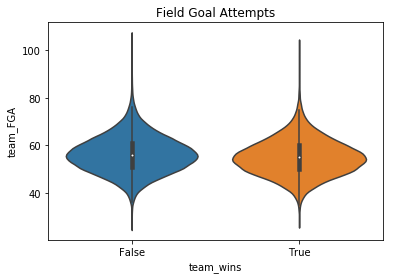

In [15]:
sns.violinplot(x="team_wins",y="team_FGA", data=team_game_log.reset_index())
plt.title("Field Goal Attempts")

Text(0.5, 1.0, 'Free Throw Attempts')

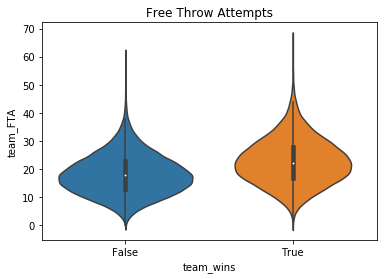

In [16]:

sns.violinplot(x="team_wins",y="team_FTA", data=team_game_log.reset_index())
plt.title("Free Throw Attempts")

A winning team's free throw attempt distribution has a larger and higher tail. Also the mean is bigger

Let's see blocks

Text(0.5, 1.0, 'Blocks')

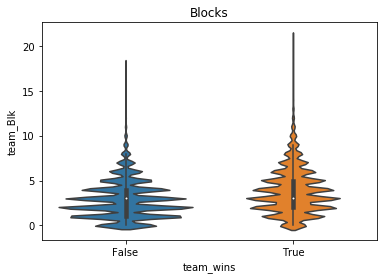

In [17]:
sns.violinplot(x="team_wins",y="team_Blk", data=team_game_log.reset_index())
plt.title("Blocks")

Similar for Blocks but in this case the medians look similar but the tail is much different. 

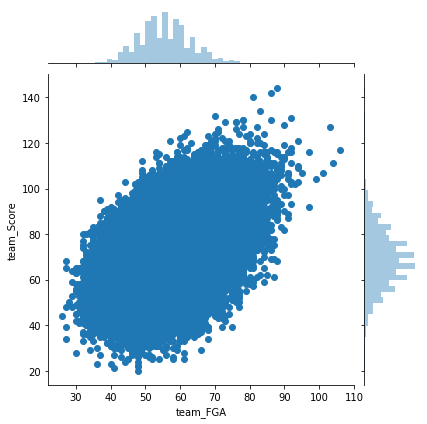

In [18]:
sns.jointplot(x="team_FGA",y="team_Score", data=team_game_log.reset_index())

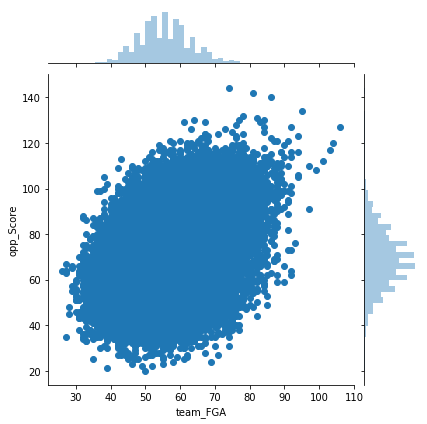

In [19]:
sns.jointplot(x="team_FGA",y="opp_Score", data=team_game_log.reset_index())

FGA have higher variance with the opponent's score due to the uncertainty of the cause of the additional attempts. Play by play could help us attribute it appropriately.

# Submit to Kaggle

First we need to add an ID that follows Kaggle's format

In [27]:
def game_index_to_kaggle_id(game_index):
    vals=game_index.split("_")
    vals.pop(1)
    return "_".join(vals)
labels['ID']=labels['game_index'].apply(game_index_to_kaggle_id)
labels['Pred']=clf.predict_proba(X)[:,1]
labels

,game_index,time,team_1_wins,ID,Pred
0,2003_145_1112_1242,2003-03-29,False,2003_1112_1242,0.564706
1,2004_136_1343_1400,2004-03-18,False,2004_1343_1400,0.368597
2,2004_139_1280_1462,2004-03-21,False,2004_1280_1462,0.724112
...,...,...,...,...,...
250,2018_146_1181_1242,2018-03-25,False,2018_1181_1242,0.455481
251,2018_152_1242_1437,2018-03-31,False,2018_1242_1437,0.504284
252,2018_154_1276_1437,2018-04-02,False,2018_1276_1437,0.289081


Now we merge with a dataframe of all possible matchups for Kaggle

In [28]:
possible_tourney_games_df=utils.build_possible_tourney_games()
predictions=possible_tourney_games_df.merge(labels,on=["ID"], how="left")
predictions['Pred']=predictions['Pred'].fillna(.5)
predictions

,Team1_ID,Team2_ID,Season,TeamID,ID,game_index,time,team_1_wins,Pred
0,1107,1110,2014,1107,2014_1107_1110,NaN,NaT,NaN,0.5
1,1107,1112,2014,1107,2014_1107_1112,NaN,NaT,NaN,0.5
2,1107,1113,2014,1107,2014_1107_1113,NaN,NaT,NaN,0.5
...,...,...,...,...,...,...,...,...,...
11387,1455,1460,2018,1455,2018_1455_1460,NaN,NaT,NaN,0.5
11388,1455,1462,2018,1455,2018_1455_1462,NaN,NaT,NaN,0.5
11389,1460,1462,2018,1460,2018_1460_1462,NaN,NaT,NaN,0.5


In [26]:
predictions[['ID','Pred']].to_csv("matchup_history_model.csv",index=False)

We're ready to submit to Kaggle! https://www.kaggle.com/c/mens-machine-learning-competition-2019/submit  
  
Our submission value should be similar to belows log-loss, with a small difference because we have a few play in games included in the prediction that Kaggle doesn't actually score)

In [51]:
kaggle_played_tourney_labels=utils.build_played_kaggle_labels(matchups_es, tourney_starts)
combined_labels=kaggle_played_tourney_labels.merge(labels, on="game_index", how="left", suffixes=["","_y"])
log_loss(combined_labels['team_1_wins'],combined_labels['Pred'].fillna(.5))

0.6438512755508682

This is not a great score on Kaggle. Only a small improvement from guessing 50% for each game. The best way to view this matchups_model is as a specialized model that provides information on matchup history when it exists. In the Kaggle submission we have a history based prediction for ~120 out of 335 predictions. Restricting that to teams that have played more than 3 in the last 5 years would reduce the number of informed predictions drastically

# Next Steps
Let me know your thoughts on everything as soon as you can. I think adding seeds would be a useful set of features and be pretty quick since I already have the ID computed in another notebook.    
  
For team_game_logs I need to switch the cutoff_time and may have some questions on that.  
  
Feature groupings could be very interesting but I'm not sure how much I will be able to do if we want to get the article out this weekend. (I think it would be ideal to have the article out by Sunday night in terms of people reading and sharing it but we would need to balance the how many things I can put into it with the time remaining).  
  
I think the article would still be highly relevant into the later rounds of the tournament and there could be a great buzz of interest from the analytics community in the mid-to-late rounds as people discuss the Elite eight final four and eventual champion as they watch their brackets closely. The Kaggle submission is due on Thursday 21st. Good early results could build article interest too.
  
